## **Importing Modules**

In [98]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import keras, nltk
from gensim.models import Word2Vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Input, Model
from keras.layers import Embedding, Dense, Conv1D, Concatenate, Dropout, MaxPooling1D, Bidirectional, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
print("GPUs: ")
print(keras.backend.tensorflow_backend._get_available_gpus())

GPUs: 
['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


## **Loading data**

The [SNLI Corpus](https://nlp.stanford.edu/projects/snli/) (version 1.0) is a collection of 570k human-written English sentence pairs manually labeled for balanced classification with the labels entailment, contradiction, and neutral, supporting the task of natural language inference (NLI), also known as recognizing textual entailment (RTE).

In [3]:
train_df = pd.read_json('data/snli_1.0_train.jsonl', lines=True)
validation_df = pd.read_json('data/snli_1.0_dev.jsonl', lines=True)
test_df = pd.read_json('data/snli_1.0_test.jsonl', lines=True)

In [4]:
train_df.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],3416050480.jpg#4,neutral,3416050480.jpg#4r1n,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,A person is training his horse for a competition.,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
1,[contradiction],3416050480.jpg#4,contradiction,3416050480.jpg#4r1c,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,"A person is at a diner, ordering an omelette.",( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
2,[entailment],3416050480.jpg#4,entailment,3416050480.jpg#4r1e,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,"A person is outdoors, on a horse.","( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
3,[neutral],2267923837.jpg#2,neutral,2267923837.jpg#2r1n,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at c...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,They are smiling at their parents,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...
4,[entailment],2267923837.jpg#2,entailment,2267923837.jpg#2r1e,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at c...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,There are children present,( There ( ( are children ) present ) ),(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...


## **Setting Parameters**

In [5]:
# Embedding Dimensions
embedding_dim = 300
# Number of Epochs
nb_epochs = 100
# Maximum length of a sentence
max_seq_len = 100
# Number of classes
nb_classes = 3

## **Preprocessing the Data**

In [6]:
# Dropping unwanted columns and renaming the remaining columns
def drop_columns(df):
    required_columns = ["sentence1", "sentence2", "gold_label"]
    return_df = df[required_columns]
    return_df.columns = ["premise", "hypothesis", "label"]
    # Dropping data with multiple labels
    return_df = return_df[return_df["label"] != "-"]
    return return_df

train_df = drop_columns(train_df)
validation_df = drop_columns(validation_df)
test_df = drop_columns(test_df)
train_df.head()

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


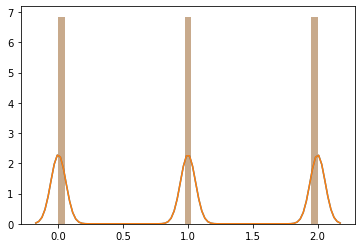

In [91]:
sns.distplot(LabelEncoder().fit_transform(train_df["label"]))
plt.show()

## Text Embeddings

In [7]:
# Create an embedding matrix from a word2vec model trained on premise texts and hypothesis texts
def create_embedding_matrix(corpus, tokenizer, vocabulary_size, embedding_dimension = embedding_dim):
    # Train a word2vec model
    wvmodel = Word2Vec(corpus, size = embedding_dimension)
    
    # Create a vocabulary dictionary
    vocabulary = {}
    for key, value in wvmodel.wv.vocab.items():
        vocabulary[key] = value
    
    # Create an embedding matrix with embedding vectors from the word2vec model
    embedding_matrix = np.zeros((vocabulary_size, embedding_dimension))
    for word, i in tokenizer.word_index.items():
        if vocabulary.get(word) is not None:
            embedding_matrix[i] = wvmodel[word]
    return embedding_matrix

## Tokenizing the data

In [8]:
# Create corpi
premise_corpus = [nltk.word_tokenize(sent) for sent in train_df["premise"]]
hypothesis_corpus = [nltk.word_tokenize(sent) for sent in train_df["hypothesis"]]

In [9]:
# Tokenize corpi
premise_tokenizer = Tokenizer(oov_token = "oov_tok")
premise_tokenizer.fit_on_texts(premise_corpus)
premise_vocab_size = len(premise_tokenizer.word_index) + 1

hypothesis_tokenizer = Tokenizer(oov_token = "oov_tok")
hypothesis_tokenizer.fit_on_texts(hypothesis_corpus)
hypothesis_vocab_size = len(hypothesis_tokenizer.word_index) + 1

## Padding the data

In [10]:
# Convert text to sequences
premise_seqs = premise_tokenizer.texts_to_sequences(premise_corpus)
hypothesis_seqs = hypothesis_tokenizer.texts_to_sequences(hypothesis_corpus)

# Pad the tokenised sequences
padded_premise_seqs = pad_sequences(premise_seqs, maxlen=max_seq_len, padding = "pre")
padded_hypothesis_seqs = pad_sequences(hypothesis_seqs, maxlen=max_seq_len, padding = "pre")

In [11]:
# Prepare validation dataset
premise_seqs_val = premise_tokenizer.texts_to_sequences([sent for sent in validation_df["premise"]])
padded_premise_seqs_val = pad_sequences(premise_seqs_val, maxlen=max_seq_len, padding = "pre")

hypothesis_seqs_val = hypothesis_tokenizer.texts_to_sequences([sent for sent in validation_df["hypothesis"]])
padded_hypothesis_seqs_val = pad_sequences(hypothesis_seqs_val, maxlen=max_seq_len, padding = "pre")

# Prepare test dataset
premise_seqs_test = premise_tokenizer.texts_to_sequences([sent for sent in test_df["premise"]])
padded_premise_seqs_test = pad_sequences(premise_seqs_test, maxlen=max_seq_len, padding = "pre")

hypothesis_seqs_test = hypothesis_tokenizer.texts_to_sequences([sent for sent in test_df["hypothesis"]])
padded_hypothesis_seqs_test = pad_sequences(hypothesis_seqs_test, maxlen=max_seq_len, padding = "pre")

## **Label Encoding**

In [12]:
# One-hot encode Labels
one_enc = OneHotEncoder(handle_unknown="ignore")
one_enc.fit(np.array(train_df["label"]).reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [13]:
train_labels = one_enc.transform(np.array(train_df["label"]).reshape(-1, 1))
val_labels = one_enc.transform(np.array(validation_df["label"]).reshape(-1, 1))
test_labels = one_enc.transform(np.array(test_df["label"]).reshape(-1, 1))
train_labels.shape

(549367, 3)

## Model Architecture

In [47]:
# Input layers
premise_inputs = Input(shape = (max_seq_len, ))
hypothesis_inputs = Input(shape = (max_seq_len, ))

In [48]:
# Creating embedding matrices for premise and hypothesis corpi
premise_embedding_matrix = create_embedding_matrix(premise_corpus, 
                                                   premise_tokenizer, 
                                                   premise_vocab_size)

hypothesis_embedding_matrix = create_embedding_matrix(hypothesis_corpus, 
                                                   hypothesis_tokenizer, 
                                                   hypothesis_vocab_size)

# Creating embedding layers with embedding matrices as weights
premise_embedding_layer = Embedding(input_dim=premise_vocab_size, 
                                    output_dim=embedding_dim, 
                                    input_length=max_seq_len, 
                                    weights = [premise_embedding_matrix], 
                                    trainable = False)(premise_inputs)
hypothesis_embedding_layer = Embedding(input_dim=hypothesis_vocab_size, 
                                    output_dim=embedding_dim, 
                                    input_length=max_seq_len, 
                                    weights = [hypothesis_embedding_matrix], 
                                    trainable = False)(hypothesis_inputs)

In [71]:
# Model architecture for premise texts
premise_model = Conv1D(64, kernel_size=3, activation = "relu")(premise_embedding_layer)
premise_model = BatchNormalization()(premise_model)
premise_model = Conv1D(64, kernel_size=3, activation = "relu")(premise_model)
premise_model = BatchNormalization()(premise_model)
premise_model = MaxPooling1D(2)(premise_model)
premise_model = Dropout(0.3)(premise_model)
premise_model = Bidirectional(LSTM(50))(premise_model)

In [72]:
# Model architecture for hypothesis texts
hypothesis_model = Conv1D(64, kernel_size=3, activation = "relu")(hypothesis_embedding_layer)
hypothesis_model = BatchNormalization()(hypothesis_model)
hypothesis_model = Conv1D(64, kernel_size=3, activation = "relu")(hypothesis_model)
hypothesis_model = BatchNormalization()(hypothesis_model)
hypothesis_model = MaxPooling1D(2)(hypothesis_model)
hypothesis_model = Dropout(0.3)(hypothesis_model)
hypothesis_model = Bidirectional(LSTM(50))(hypothesis_model)

In [73]:
# Concatening the premise and hypothesis models
x = Concatenate()([premise_model, hypothesis_model])
# DNN
x = Dense(256, activation = "relu")(x)
x = Dropout(0.3)(x)
output = Dense(nb_classes, activation = "softmax")(x)
model = Model([premise_inputs, hypothesis_inputs], output)

In [74]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     6903000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 300)     11030400    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_20 

In [75]:
# Compiling the model
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [76]:
# Early stop callback
early_stop = EarlyStopping(monitor = "val_loss", patience = 5)

## Training the model

In [ ]:
# Fitting the data
history = model.fit(x = [padded_premise_seqs, padded_hypothesis_seqs], 
                    y = train_labels, 
                    validation_data = ([padded_premise_seqs_val, padded_hypothesis_seqs_val], val_labels),
                    shuffle = True,
                    epochs = nb_epochs,
                    batch_size = 64,
                    callbacks = [early_stop]
                   )

Train on 549367 samples, validate on 9842 samples
Epoch 1/100
549367/549367 [==============================] - 1516s 3ms/step - loss: 0.8881 - acc: 0.5885 - val_loss: 0.8393 - val_acc: 0.6221
Epoch 2/100
549367/549367 [==============================] - 1508s 3ms/step - loss: 0.8187 - acc: 0.6316 - val_loss: 0.8059 - val_acc: 0.6369
Epoch 3/100
549367/549367 [==============================] - 1508s 3ms/step - loss: 0.7905 - acc: 0.6485 - val_loss: 0.7980 - val_acc: 0.6443
Epoch 4/100
549367/549367 [==============================] - 1508s 3ms/step - loss: 0.7720 - acc: 0.6579 - val_loss: 0.7704 - val_acc: 0.6656
Epoch 5/100
549367/549367 [==============================] - 1508s 3ms/step - loss: 0.7566 - acc: 0.6666 - val_loss: 0.7515 - val_acc: 0.6760
Epoch 6/100
549367/549367 [==============================] - 1507s 3ms/step - loss: 0.7432 - acc: 0.6742 - val_loss: 0.7454 - val_acc: 0.6775
Epoch 7/100
549367/549367 [==============================] - 1508s 3ms/step - loss: 0.7328 - acc: 

## Evaluating model on test set

In [80]:
_, acc = model.evaluate([padded_premise_seqs_test, padded_hypothesis_seqs_test], test_labels)
print("Accuracy on test set : ", round(acc*100, 3))

9824/9824 [==============================] - 12s 1ms/step
Accuracy on test set :  73.402


## Classification Report

In [97]:
test_pred = model.predict([padded_premise_seqs_test, padded_hypothesis_seqs_test])

In [109]:
print(classification_report(np.argmax(test_labels, axis = 1), np.argmax(test_pred, axis = 1), target_names=one_enc.categories_[0].tolist()))

               precision    recall  f1-score   support

contradiction       0.80      0.69      0.74      3237
   entailment       0.73      0.78      0.75      3368
      neutral       0.69      0.73      0.71      3219

     accuracy                           0.73      9824
    macro avg       0.74      0.73      0.73      9824
 weighted avg       0.74      0.73      0.73      9824

